In [23]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
import joblib

In [24]:
try:
    df = pd.read_csv("Datasets/accesos_biblioteca.csv")
    print("Dataset cargado desde 'Datasets/accesos_biblioteca.csv'")
except FileNotFoundError:
    print("ERROR: No se encontró el archivo 'accesos_biblioteca.csv'.")
    exit(1)

Dataset cargado desde 'Datasets/accesos_biblioteca.csv'


In [34]:
print("Dataset original - Columnas iniciales:")
print(f"Columnas: {list(df.columns)}")
print(f"Forma del dataset: {df.shape}")
print("\nPrimeras 3 filas:")
print(df.head(3))

Dataset original - Columnas iniciales:
Columnas: ['Fecha', 'Día', 'Mes', 'Año', 'Semestre', 'Accesos', 'Vacaciones?', 'media_movil_7', 'media_movil_14', 'media_movil_30', 'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos', 'ewma_7', 'ewma_14', 'ewma_30', 'Semana_Semestre', 'lag_7', 'lag_14', 'lag_21']
Forma del dataset: (417, 21)

Primeras 3 filas:
       Fecha  Día  Mes   Año  Semestre  Accesos  Vacaciones?  media_movil_7  \
0 2024-01-08    8    1  2024         0      212            0     206.428571   
1 2024-01-09    9    1  2024         0      283            0     236.714286   
2 2024-01-10   10    1  2024         0      185            0     277.142857   

   media_movil_14  media_movil_30  ...   mes_cos  dia_semana_sin  \
0      111.928571      224.380952  ...  0.866025        0.000000   
1      118.357143      223.818182  ...  0.866025        0.781831   
2      138.571429      226.391304  ...  0.866025        0.974928   

   dia_semana_cos      ewma_7     ewma_14     ewma_30

In [35]:
def agregar_lags(df, columna, lags):
    for lag in lags:
        df[f'lag_{lag}'] = df[columna].shift(lag)
    return df

def agregar_medias_moviles(df, columna, ventanas):
    for ventana in ventanas:
        df[f'media_movil_{ventana}'] = df[columna].shift(1).rolling(window=ventana, min_periods=1).mean()
    return df

def agregar_variables_ciclicas(df, columna_mes, columna_fecha):
    df['mes_sin'] = np.sin(2 * np.pi * df[columna_mes] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df[columna_mes] / 12)
    df['dia_semana_sin'] = np.sin(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    return df

def agregar_ewma(df, columna, spans):
    for span in spans:
        df[f'ewma_{span}'] = df[columna].shift(1).ewm(span=span, adjust=False).mean()
    return df


In [36]:
def obtener_semestre(mes):
    if 3 <= mes <= 7:
        return 1  # Primer semestre
    elif 8 <= mes <= 12:
        return 2  # Segundo semestre
    else:
        return 0  # Fuera de semestre (enero, febrero)
    
def obtener_semana_semestre(fecha):
    mes = fecha.month
    dia = fecha.day
    if 3 <= mes <= 7:
        inicio_semestre = datetime(fecha.year, 3, 1)
    elif 8 <= mes <= 12:
        inicio_semestre = datetime(fecha.year, 8, 1)
    else:
        return 0  # Fuera de semestre
    delta = fecha - inicio_semestre
    semana_semestre = delta.days // 7 + 1
    return semana_semestre

In [37]:
for col in ['Accesos']:
    df[col] = df[col].fillna(0).astype(int)

df = df[
    pd.to_datetime(df['Fecha']).dt.weekday != 6
].reset_index(drop=True)

df = agregar_medias_moviles(df, 'Accesos', [7, 14, 30])
df = agregar_variables_ciclicas(df, 'Mes', 'Fecha')
df = agregar_ewma(df, 'Accesos', [7, 14, 30])

df['Semestre'] = df['Mes'].apply(obtener_semestre)
df['Semana_Semestre'] = pd.to_datetime(df['Fecha']).apply(obtener_semana_semestre)

df['Fecha'] = pd.to_datetime(df['Fecha'])

df = agregar_lags(df, 'Accesos', [7, 14, 21])

df = df.dropna().reset_index(drop=True)
df.tail(5)

,Fecha,Día,Mes,Año,Semestre,Accesos,Vacaciones?,media_movil_7,media_movil_14,media_movil_30,...,mes_cos,dia_semana_sin,dia_semana_cos,ewma_7,ewma_14,ewma_30,Semana_Semestre,lag_7,lag_14,lag_21
391,2025-05-02,2,5,2025,1,0,1,1585.571429,1941.642857,2525.500000,...,-0.866025,-0.433884,-0.900969,1525.983140,1921.208321,2153.063866,9,2544.0,4145.0,3923.0
392,2025-05-03,3,5,2025,1,0,1,1222.142857,1645.571429,2445.066667,...,-0.866025,-0.974928,-0.222521,1144.487355,1665.047212,2014.156520,10,1356.0,1592.0,4248.0
393,2025-05-05,5,5,2025,1,2750,0,1028.428571,1531.857143,2438.466667,...,-0.866025,0.000000,1.000000,858.365516,1443.040917,1884.210938,10,526.0,0.0,3976.0
394,2025-05-06,6,5,2025,1,1866,0,1346.142857,1728.285714,2417.700000,...,-0.866025,0.781831,0.623490,1331.274137,1617.302128,1940.068296,10,2400.0,0.0,3140.0
395,2025-05-07,7,5,2025,1,2254,0,1269.857143,1861.571429,2362.766667,...,-0.866025,0.974928,-0.222521,1464.955603,1650.461844,1935.289697,10,2568.0,3841.0,852.0


In [44]:
print(" Nuevas columnas creadas \n")

# Columnas originales del dataset base
columnas_originales = ['Fecha', 'Día', 'Mes', 'Año', 'Vacaciones', 'Accesos']

# Mostrar todas las columnas actuales
columnas_actuales = list(df.columns)
nuevas_columnas = [col for col in columnas_actuales if col not in columnas_originales]

print(" Dataset original - Columnas iniciales:")
print(f"   Columnas: {columnas_originales}")
print(f"   Total: {len(columnas_originales)} columnas\n")

print(" Nuevas columnas agregadas:")
for i, col in enumerate(nuevas_columnas, 1):
    print(f"   {i:2d}. {col}")

print(f" Resumen de columnas")
print(f" Columnas originales: {len(columnas_originales)}")
print(f" Nuevas columnas: {len(nuevas_columnas)}")
print(f" Total final: {len(columnas_actuales)} columnas")
print(f" Shape del dataset: {df.shape}")

print(f" Categorías de nuevas características:")
print("  Variables de tendencia: media_movil_7, media_movil_14, media_movil_30")
print("  Variables cíclicas: mes_sin, mes_cos, dia_semana_sin, dia_semana_cos") 
print("  Medias exponenciales: ewma_7, ewma_14, ewma_30")
print("  Variables académicas: Semestre, Semana_Semestre, Semana_Certamen")
print("  Variables lag: lag_7, lag_14, lag_21 (se agregarán después)")

# Mostrar una muestra del dataset con las nuevas columnas
print("\n Muestra del Dataset con nuevas columnas:")
print(df[['Fecha', 'Accesos'] + nuevas_columnas[:5]].head(3))

 Nuevas columnas creadas 

 Dataset original - Columnas iniciales:
   Columnas: ['Fecha', 'Día', 'Mes', 'Año', 'Vacaciones', 'Accesos']
   Total: 6 columnas

 Nuevas columnas agregadas:
    1. Semestre
    2. Vacaciones?
    3. media_movil_7
    4. media_movil_14
    5. media_movil_30
    6. mes_sin
    7. mes_cos
    8. dia_semana_sin
    9. dia_semana_cos
   10. ewma_7
   11. ewma_14
   12. ewma_30
   13. Semana_Semestre
   14. lag_7
   15. lag_14
   16. lag_21
 Resumen de columnas
 Columnas originales: 6
 Nuevas columnas: 16
 Total final: 21 columnas
 Shape del dataset: (396, 21)
 Categorías de nuevas características:
  Variables de tendencia: media_movil_7, media_movil_14, media_movil_30
  Variables cíclicas: mes_sin, mes_cos, dia_semana_sin, dia_semana_cos
  Medias exponenciales: ewma_7, ewma_14, ewma_30
  Variables académicas: Semestre, Semana_Semestre, Semana_Certamen
  Variables lag: lag_7, lag_14, lag_21 (se agregarán después)

 Muestra del Dataset con nuevas columnas:
       

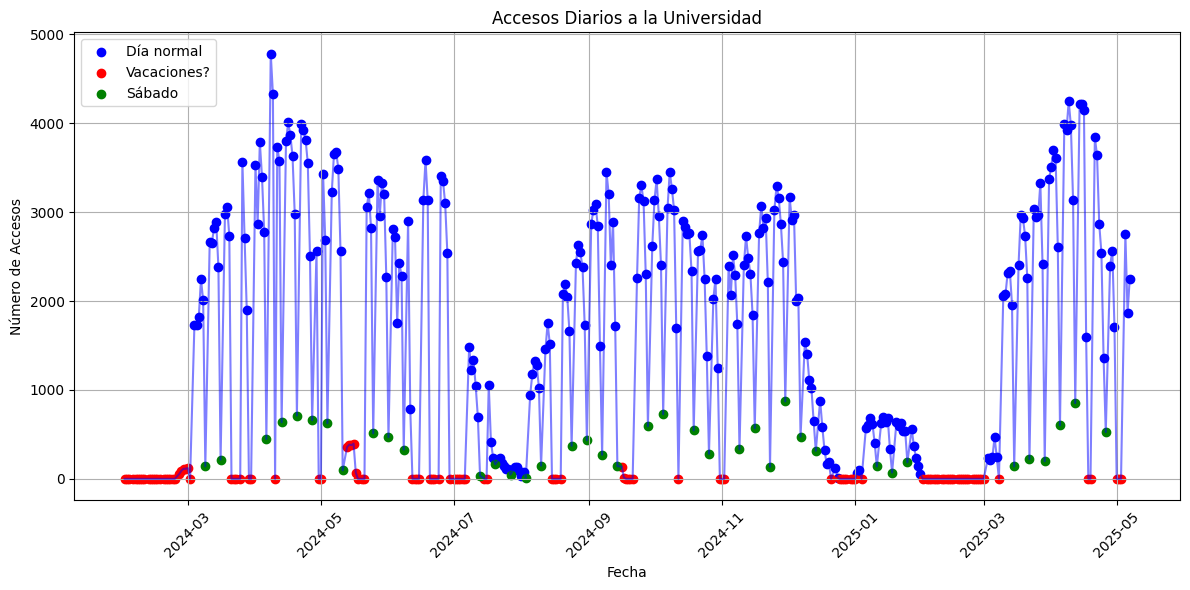

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(df['Fecha'], df['Accesos'], linestyle='-', color='b', alpha=0.5)

# Puntos normales (no vacaciones ni sábados)
no_vac_no_sab = (df['Vacaciones?'] == 0) & (df['Fecha'].dt.weekday != 5)
plt.scatter(df['Fecha'][no_vac_no_sab], df['Accesos'][no_vac_no_sab], color='b', label='Día normal')

# Puntos de vacaciones
vac = (df['Vacaciones?'] == 1)
plt.scatter(df['Fecha'][vac], df['Accesos'][vac], color='r', label='Vacaciones?')

# Puntos de sábados
sab = (df['Vacaciones?'] == 0) & (df['Fecha'].dt.weekday == 5)
plt.scatter(df['Fecha'][sab], df['Accesos'][sab], color='g', label='Sábado')

plt.title('Accesos Diarios a la Universidad')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

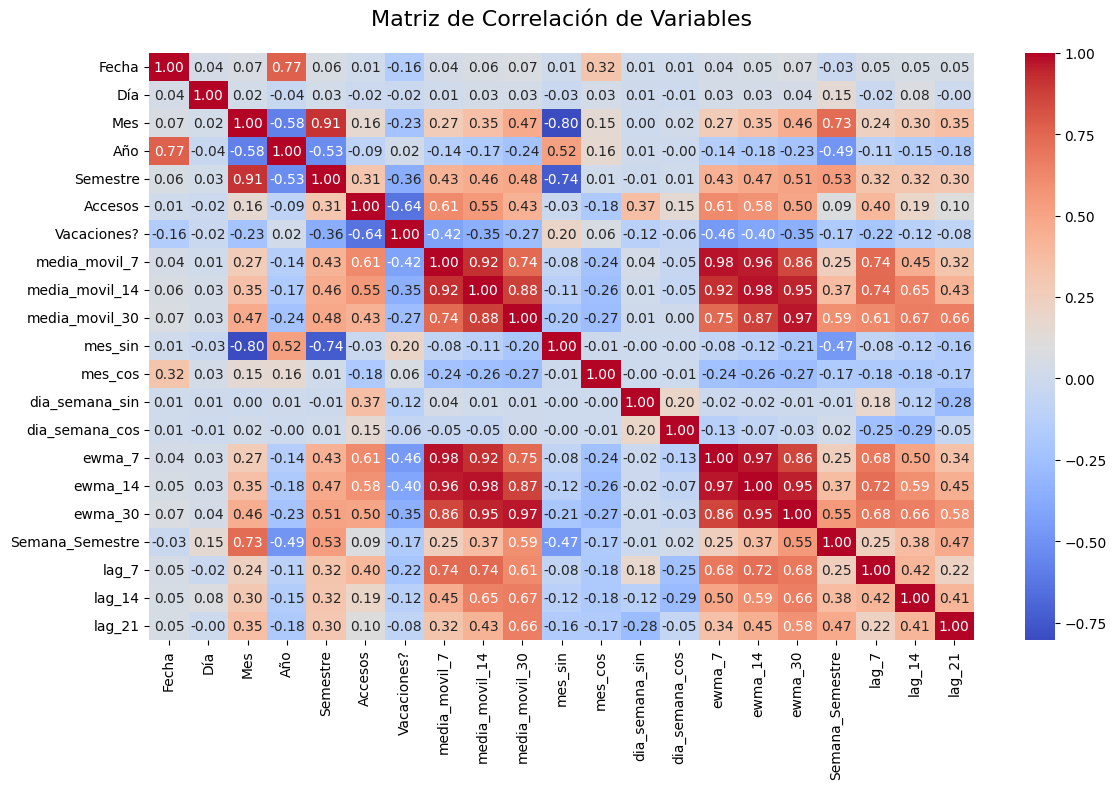

In [58]:
# Matriz de coorrelación
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlación de Variables', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [65]:
X = df.drop(columns=['Fecha', 'Accesos'])
y = df['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Datos de entrenamiento: {len(X_train)}")
print(f"Datos de prueba: {len(X_test)}")

Datos de entrenamiento: 316
Datos de prueba: 80


In [71]:
print("Dataset final después de ingeneiría de características\n")

# Mostrar todas las columnas finales organizadas por categoría
print("Columnas organizadas por categoría:")

print("\n Variables originales:")
originales = ['Fecha', 'Día', 'Mes', 'Año', 'Vacaciones', 'Accesos']
for col in originales:
    if col in df.columns:
        print(f" {col}")

print("\n Variables de tendencia/suavizado:")
tendencia = [col for col in df.columns if 'media_movil' in col or 'ewma' in col]
for col in tendencia:
    print(f" {col}")

print("\n Variables cíclicas/temporales:")
ciclicas = [col for col in df.columns if any(x in col for x in ['sin', 'cos'])]
for col in ciclicas:
    print(f" {col}")

print("\n Variables del contexto académico:")
academicas = [col for col in df.columns if any(x in col for x in ['Semestre', 'Semana', 'Certamen'])]
for col in academicas:
    print(f" {col}")

print("\n Variables lag (retardos temporales):")
lags = [col for col in df.columns if 'lag_' in col]
for col in lags:
    print(f" {col}")

print(f"\n Resumen Final:")
print(f" Total de columnas: {len(df.columns)}")
print(f" Filas en el dataset: {len(df)}")
print(f" Nuevas características creadas: {len(df.columns) - 6}")  # 6 son las originales

Dataset final después de ingeneiría de características

Columnas organizadas por categoría:

 Variables originales:
 Fecha
 Día
 Mes
 Año
 Accesos

 Variables de tendencia/suavizado:
 media_movil_7
 media_movil_14
 media_movil_30
 ewma_7
 ewma_14
 ewma_30

 Variables cíclicas/temporales:
 mes_sin
 mes_cos
 dia_semana_sin
 dia_semana_cos

 Variables del contexto académico:
 Semestre
 Semana_Semestre

 Variables lag (retardos temporales):
 lag_7
 lag_14
 lag_21

 Resumen Final:
 Total de columnas: 21
 Filas en el dataset: 396
 Nuevas características creadas: 15


In [112]:
# Entrenamiento y Evaluación con LightGBM
# Configuración de búsqueda de hiperparámetros
os.makedirs('Archivos Auxiliares', exist_ok=True)
if "modelo_LightGBM.pkl" not in os.listdir('Archivos Auxiliares'):
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'learning_rate': [0.005, 0.1],
        'n_estimators': [500, 2000],
        'num_leaves': [20, 128],
        # opcional (incluye solo si sospechas overfit)
        'max_depth': [5, 8, 10, 15],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
    }


    print("\nIniciando entrenamiento y ajuste de hiperparámetros de LightGBM...")

    # 1. Búsqueda de Hyperparámetros
    grid_search = GridSearchCV(
        lgb.LGBMRegressor(random_state=42, n_jobs=-1, objective='regression'),
        param_grid,  # Usando el conjunto de parámetros mejorado
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=2 # Aumentamos el verbose para seguir mejor el progreso
    )

    grid_search.fit(X_train, y_train)

    print(f'Mejores parámetros para LightGBM: {grid_search.best_params_}')

    # 2. Entrenamiento del modelo final con los mejores parámetros
    best_params = grid_search.best_params_
    model = lgb.LGBMRegressor(**best_params, random_state=42, n_jobs=-1, objective='regression')
    model.fit(X_train, y_train)
    joblib.dump(model, 'Archivos Auxiliares/modelo_LightGBM.pkl')
    print("Modelo LightGBM guardado como 'Archivos Auxiliares/modelo_LightGBM.pkl'")
# Guardar el modelo
else:
    model = joblib.load('Archivos Auxiliares/modelo_LightGBM.pkl')
    print("Modelo LightGBM cargado desde 'Archivos Auxiliares/modelo_LightGBM.pkl'")

Modelo LightGBM cargado desde 'Archivos Auxiliares/modelo_LightGBM.pkl'


In [113]:
# Importancia de las características
importancias = model.feature_importances_
indices = np.argsort(importancias)[::-1]
print("\nImportancia de las características\n")
for i, idx in enumerate(indices):
    if idx < len(X.columns):
        print(f"{i + 1:2d}. {X.columns[idx]}: {importancias[idx]:.4f}")


Importancia de las características

 1. dia_semana_cos: 449.0000
 2. media_movil_14: 298.0000
 3. Año: 198.0000
 4. mes_sin: 156.0000
 5. mes_cos: 154.0000
 6. Vacaciones?: 139.0000
 7. Semestre: 124.0000
 8. media_movil_30: 97.0000
 9. ewma_14: 57.0000
10. dia_semana_sin: 57.0000
11. media_movil_7: 50.0000
12. Mes: 30.0000
13. ewma_7: 19.0000
14. Día: 0.0000


In [114]:
# Eliminar características con importancia menor a 50
umbral_importancia = 50

# Solo considera las columnas usadas por el modelo y presentes en X_train/X_test
columnas_modelo = X.columns[:len(importancias)]
FEATURES = [col for col, imp in zip(columnas_modelo, importancias) 
            if imp >= umbral_importancia and col in X_train.columns and col in X_test.columns]

X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

# Reentrenar el modelo con las características seleccionadas
model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 7
[LightGBM] [Info] Start training from score 1369.101266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.01
,n_estimators,200
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [115]:
# Evaluación de rendimiento
predicted = model.predict(X_test)
predicted = np.maximum(predicted, 0)


 Evaluación de rendimiento de LightGBM en el set de prueba
R²: 0.69
Error Cuadrático Medio (MSE): 728311.01
Error Cuadrático Medio Raíz (RMSE): 853.41
Error Absoluto Medio (MAE): 624.38

Se han generado las siguientes visualizaciones:
- lightgbm_predicciones.png (Comparación de valores reales vs. predichos)
- lightgbm_importancia.png (Importancia de las variables)


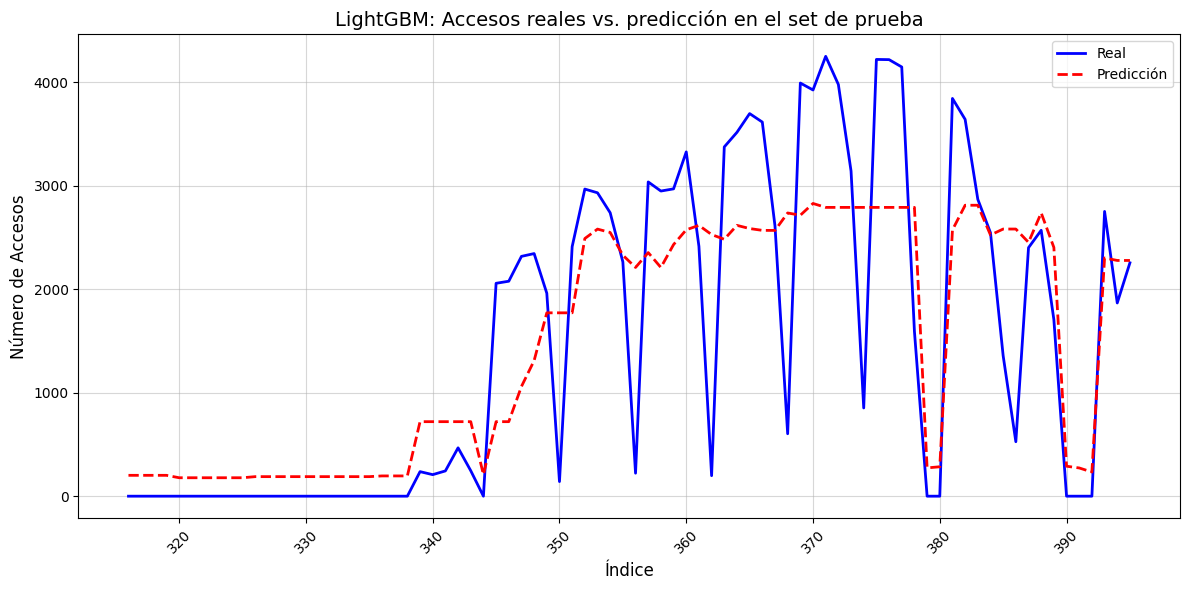

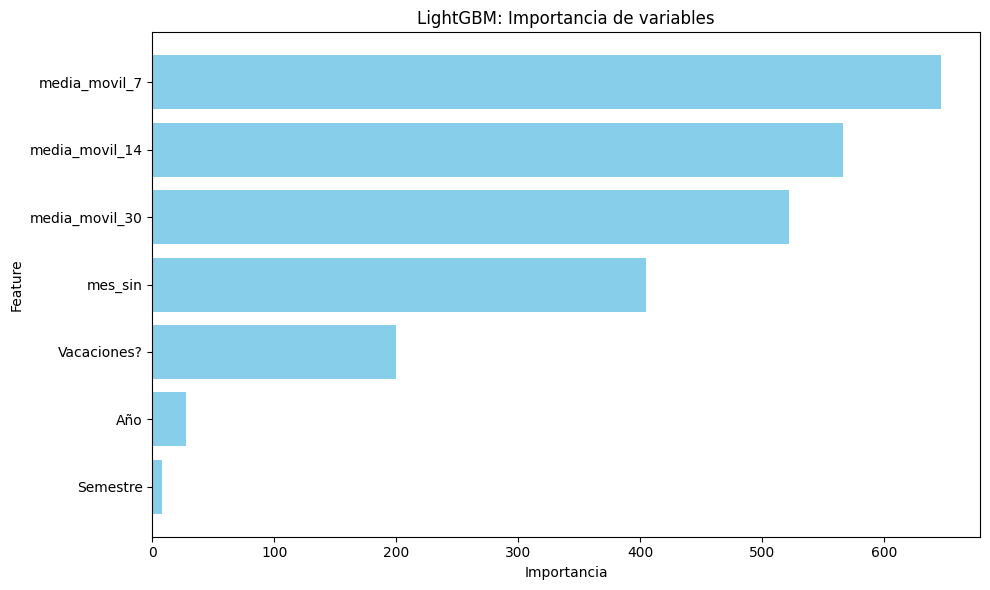

In [116]:
# Cálculo de métricas
mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print("\n Evaluación de rendimiento de LightGBM en el set de prueba")
print(f"R²: {r2:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Error Cuadrático Medio Raíz (RMSE): {rmse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")

# Graficar resultados de la predicción (Real vs. Predicción en el test set)
results_df = pd.DataFrame({
    'Índice': X_test.index,
    'Real': y_test,
    'Predicción': predicted
}).sort_values(by='Índice')

plt.figure(figsize=(12, 6))
plt.plot(results_df['Índice'], results_df['Real'], label='Real', color='blue', linewidth=2)
plt.plot(results_df['Índice'], results_df['Predicción'], label='Predicción', color='red', linestyle='--', linewidth=2)
plt.title('LightGBM: Accesos reales vs. predicción en el set de prueba', fontsize=14)
plt.xlabel('Índice', fontsize=12)
plt.ylabel('Número de Accesos', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('lightgbm_predicciones.png')

# Graficar importancia de variables
importances = model.feature_importances_
importance_df = pd.DataFrame({"Feature": FEATURES, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("LightGBM: Importancia de variables")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('lightgbm_importancia.png')

print("\nSe han generado las siguientes visualizaciones:")
print("- lightgbm_predicciones.png (Comparación de valores reales vs. predichos)")
print("- lightgbm_importancia.png (Importancia de las variables)")